# Using ISCE to generate interferograms from Stripmap mode data

In conventional stripmap Synthetic Aperture Radar(SAR) imaging mode, the radar antenna
is fixed to a specific direction, illuminating a single swath of the scene with a fixed squint angle (i.e., the angle between the radar beam and the cross-track direction). The imaging swath width can be increased using the scanning SAR (ScanSAR) or Terrain Observation by Progressive Scan(TOPS). In this notebook we focus on interferometric processing of stripmap data using stripmapApp.py. 

The stripmap mode has been used by sevreal SAR missions, such as Envisat, ERS, RadarSAT-1, Radarsat-2, ALOS-1, Cosmo Sky-Med and TerraSAR-X. Although Sentinel-1 A/B and ALOS-2 are capable of acuqiring SAR data with stripmap mode, their operational imaging modes are TOPS and ScanSAR respectively. Both missions have been acquiring stripmap data over certain regions.

For processing TOPS data using topsApp, please see the topsApp notebook. However, we recommend that new InSAR users may start with the stripmapApp notebook first, and then try the topsApp notebook. 

The detailed algorithms for stripmap processing and TOPS processing implemented in ISCE software can be found in the following literatures:

### stripmapApp:

H. Fattahi, M. Simons, and P. Agram,  "InSAR Time-Series Estimation of the Ionospheric Phase Delay: An Extension of the Split Range-Spectrum Technique", IEEE Trans. Geosci. Remote Sens., vol. 55, no. 10, 5984-5996, 2017.
(https://ieeexplore.ieee.org/abstract/document/7987747/)

### topsApp:

H. Fattahi, P. Agram, and M. Simons, “A network-based enhanced spectral diversity approach for TOPS time-series analysis,” IEEE Trans. Geosci. Remote Sens., vol. 55, no. 2, pp. 777–786, Feb. 2017. (https://ieeexplore.ieee.org/abstract/document/7637021/)

### ISCE framework:
Rosen et al, IGARSS 2018 [Complete reference here] 

![title](notebook_docs/Stripmap_Tops.png)

(Figure from Fattahi et. al., 2017)

# stripmapApp (general overview)

stripmapApp.py is an ISCE application, designed for interferometric processing of SAR data acquired with stripmap mode onboard platforms with precise orbits. This ISCE application is equivalent to insarApp (an older ISCE application which has been widely used by ISCE users), in this sense that both apps process stripmap data. Although the naming convention of the products and interface of the App is similiar to insarApp, the core modules used in stripmapApp are fundamentally different. The main features of stripmapApp includes the following:

#### a) Focusing RAW data to native Doppler:

If processing starts from RAW data, JPL's ROI software is used for focusing the raw data to SLC(Single Look Complex) SAR images in native Doppler geometry. stripmapApp does not use the motion compensation algorithm which was used in insarApp. 

#### b) Interferometric processing of SLCs in native or zero Doppler geometry 
If the input data are SLC images, then focusing is not required and will be skipped. stripmapApp can process SLCs focused to zero or native Dopplers

#### c) Coregistration using SAR acquisition geometry (Orbit + DEM) 
The geometry module of ISCE is used for coregistration of SAR images, i.e., range and azimuth offsets are computed for each pixel using SAR acquisition geometry, orbit information and an existing Digital Elevation Model(DEM). The geometrical offsets are refined with a small constant shift in range and azimuth directions. The constant shifts are estimated using incoherent cross-correlation of the two SAR images already coregistered using pure geometrical information. 

#### d) Optional rubbersheeting step
An optional step called "rubbersheeting" is available for more precise coregistration in the presence of distortions due to large deformation or ionosphere. If "rubbersheeting" is requested, a dense azimuth offsets is computed using incoherent cross-correlation between the two SAR images, and is added to the geometrical offsets for more precise coregistration. 

#### e) Ionospheric phase estimation
Split Range-Spectrum technique and ionospheric phase estimation are available as optional processing steps.



# Prepare directories, download raw data

Importing some python modules and setting up some variables: 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gdal

#Add your ASF user name and password here
ASF_USER = ""
ASF_PASS = ""

# the working directory:
home_dir = os.path.abspath(".")
PROCESS_DIR = os.path.join(home_dir, "Hawaii_ALOS1")
DATA_DIR =  os.path.join(PROCESS_DIR, "data")

print("home directory: ", home_dir)


home directory:  /Users/fattahi/projects/UnavcoCourse/2018/stripmapApp


Check if the PROCESS_DIR and DATA_DIR already exist. If they don't exist, we create them:

In [3]:

if not os.path.exists(PROCESS_DIR):
    print("create ", PROCESS_DIR)
    os.makedirs(PROCESS_DIR)
else:
    print(PROCESS_DIR, " already exists!")

if not os.path.exists(DATA_DIR):
    print("create ", DATA_DIR)
    os.makedirs(DATA_DIR)
else:
    print(DATA_DIR, " already exists!")

/Users/fattahi/projects/UnavcoCourse/2018/stripmapApp/Hawaii_ALOS1  already exists!
/Users/fattahi/projects/UnavcoCourse/2018/stripmapApp/Hawaii_ALOS1/data  already exists!


go to the DATA_DIR:

In [67]:
os.chdir(DATA_DIR)

In this tutorial we will process two ALOS1 PALSAR acquistions over Hawaii. The two acquisitions cover a dike opening event in March 2011.
![title](notebook_docs/Hawaii.png)

Download two ALOS-1 acquistions from ASF using the following command:


In [4]:
cmd = "wget  https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP265743230-L1.0.zip --user={0} --password={1}".format(ASF_USER, ASF_PASS)
if not os.path.exists(os.path.join(DATA_DIR, "ALPSRP265743230-L1.0.zip")):
    os.system(cmd)
else:
    print("ALPSRP265743230-L1.0.zip already exists")
    
cmd = "wget  https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP272453230-L1.0.zip --user={0} --password={1}".format(ASF_USER, ASF_PASS)
if not os.path.exists(os.path.join(DATA_DIR, "ALPSRP272453230-L1.0.zip")):
    os.system(cmd)
else:
    print("ALPSRP272453230-L1.0.zip already exists")

Now the data should be downloading from ASF. Check the terminal that you strated your jupyter notebook from and you should see the progress bar for the download 

In [5]:
#Alternative ssara command
#!ssara_federated_query.py --platform=ALOS --intersectsWith='POLYGON((-155.3 19.5, -155.3 19.8,-155.0 19.8,-155.0 19.5, -155.3 19.5 ))' --print --kml --flightDirection=D --beamMode=FBS,FBD --relativeOrbit=598   -s 2011-01-17 -e 2011-03-07 --download

In [68]:
ls 

20110119/                 ALPSRP265743230-L1.0.zip
20110306/                 ALPSRP272453230-L1.0.zip


unzip the downloaded files

In [70]:
!unzip ALPSRP265743230-L1.0.zip
!unzip ALPSRP272453230-L1.0.zip

Archive:  ALPSRP265743230-L1.0.zip
   creating: ALPSRP265743230-L1.0/
  inflating: ALPSRP265743230-L1.0/IMG-HH-ALPSRP265743230-H1.0__D  
  inflating: ALPSRP265743230-L1.0/IMG-HV-ALPSRP265743230-H1.0__D  
  inflating: ALPSRP265743230-L1.0/VOL-ALPSRP265743230-H1.0__D  
  inflating: ALPSRP265743230-L1.0/LED-ALPSRP265743230-H1.0__D  
  inflating: ALPSRP265743230-L1.0/TRL-ALPSRP265743230-H1.0__D  
  inflating: ALPSRP265743230-L1.0/workreport  
  inflating: ALPSRP265743230-L1.0/ALPSRP265743230.l0.workreport  
Archive:  ALPSRP272453230-L1.0.zip
   creating: ALPSRP272453230-L1.0/
  inflating: ALPSRP272453230-L1.0/IMG-HH-ALPSRP272453230-H1.0__D  
  inflating: ALPSRP272453230-L1.0/IMG-HV-ALPSRP272453230-H1.0__D  
  inflating: ALPSRP272453230-L1.0/VOL-ALPSRP272453230-H1.0__D  
  inflating: ALPSRP272453230-L1.0/LED-ALPSRP272453230-H1.0__D  
  inflating: ALPSRP272453230-L1.0/TRL-ALPSRP272453230-H1.0__D  
  inflating: ALPSRP272453230-L1.0/workreport  
  inflating: ALPSRP272453230-L1.0/ALPSRP27245323

 looking at the unzipped directories there are multiple files:

In [71]:
ls ALPSRP265743230-L1.0

ALPSRP265743230.l0.workreport   TRL-ALPSRP265743230-H1.0__D
IMG-HH-ALPSRP265743230-H1.0__D  VOL-ALPSRP265743230-H1.0__D
IMG-HV-ALPSRP265743230-H1.0__D  workreport
LED-ALPSRP265743230-H1.0__D


When you download PALSAR data from a data provider, each frame comprises an image data file and an image leader file, as well as possibly some other ancillary files that are not used by ISCE.  

Files with IMG as prefix are images. 
Files with LED as prefix are leaders. 

The leader file contains parameters of the sensor that are relevant to the imaging mode, all the information necessary to process the data.  The data file contains the raw data samples if Level 1.0 raw data (this is just a different name from what other satellites call Level 0) and processed imagery if Level 1.1 or 1.5 image data.  The naming convention for these files is standardized across data archives, and has the following taxonomy:


![title](notebook_docs/ALOS1_PALSAR.png)


To see the acquisition date of this PALSAR acquisition we can look at the following file:

In [12]:
!cat ALPSRP265743230-L1.0/ALPSRP265743230.l0.workreport

Odi_ProductManagementNo            = "X0200065"
Odi_ProductManagementBranchNo      = "815"
Scs_SceneID                        = "ALPSRP265743230"
Pds_ProductID                      = "H1.0__D"
Pds_OrbitDataPrecision             = "Precision"
Pds_AttitudeDataPrecision          = "Standard"
Img_SceneCenterDateTime            = "20110119 20:33:44.268"
Img_SceneStartDateTime             = "20110119 20:33:36.068"
Img_SceneEndDateTime               = "20110119 20:33:52.468"
Img_NoOfPSR10LossLines             = "0"
Pdi_ProductDataSize                = "756.4"
Pdi_CntOfL10ProductFileName        = "5"
Pdi_L10ProductFileName01           = "VOL-ALPSRP265743230-H1.0__D"
Pdi_L10ProductFileName02           = "LED-ALPSRP265743230-H1.0__D"
Pdi_L10ProductFileName03           = "IMG-HH-ALPSRP265743230-H1.0__D"
Pdi_L10ProductFileName04           = "IMG-HV-ALPSRP265743230-H1.0__D"
Pdi_L10ProductFileName05           = "TRL-ALPSRP265743230-H1.0__D"
Pdi_NoOfPixels                     = "5968"
Pdi_NoOfLines  

In [13]:
!grep Img_SceneCenterDateTime ALPSRP265743230-L1.0/ALPSRP265743230.l0.workreport
!grep Img_SceneCenterDateTime ALPSRP272453230-L1.0/ALPSRP272453230.l0.workreport

Img_SceneCenterDateTime            = "20110119 20:33:44.268"
Img_SceneCenterDateTime            = "20110306 20:32:42.519"


for clarity let's create two directories for the two acquisition dates and move the unziped folders there:

In [14]:
!mkdir 20110119
!mkdir 20110306
!mv ALPSRP265743230-L1.0 20110119
!mv ALPSRP272453230-L1.0 20110306

Now that we have the data ready let's cd to the main PROCESS directroy

In [4]:
os.chdir(PROCESS_DIR)

To make sure where we are, run pwd:

In [16]:
!pwd

/Users/fattahi/projects/UnavcoCourse/2018/stripmapApp/Hawaii_ALOS1


# Setting up input xml files for processing with stripmapApp

Create master.xml file to point to the master Raw data or SLC images.

Here is an example master.xml file for this tutorial:

### master.xml

```xml
<component>
    <property name="IMAGEFILE">
       <value>[data/20110119/ALPSRP265743230-L1.0/IMG-HH-ALPSRP265743230-H1.0__D]</value>
    </property>
    <property name="LEADERFILE">
        <value>[data/20110119/ALPSRP265743230-L1.0/LED-ALPSRP265743230-H1.0__D]</value>
    </property>
    <property name="OUTPUT">
        <value>20110119</value>
    </property>
</component>
```

### slave.xml

```xml
<component>
    <property name="IMAGEFILE">
        <value>[data/20110306/ALPSRP272453230-L1.0/IMG-HH-ALPSRP272453230-H1.0__D]</value>
    </property>
    <property name="LEADERFILE">
        <value>[data/20110306/ALPSRP272453230-L1.0/LED-ALPSRP272453230-H1.0__D]</value>
    </property>
    <property name="OUTPUT">
        <value>20110306</value>
    </property>

</component>
```

### stripmapApp.xml



```xml
<?xml version="1.0" encoding="UTF-8"?>
<stripmapApp>
  <component name="insar">
    <property name="sensor name">ALOS</property>
    <component name="master">
        <catalog>master.xml</catalog>
    </component>
    <component name="slave">
        <catalog>slave.xml</catalog>
    </component>

    <!--  
    <property name="demFilename">
        <value>demLat_N18_N21_Lon_W156_W154.dem.wgs84</value>
    </property>
    -->
      
    <property name="unwrapper name">icu</property>
     
</component>
</stripmapApp>
```

<br>
<div class="alert alert-info">
<b>Note :</b> 

demFilename is commented out in the stripmapApp.xml. This means that user has not specified the DEM. Therefore, isce looks online and download the SRTM dem.

</div>


After downloading the data to process, and setting up the input xml files, we are ready to start processing with stripmapApp. To see a full list of the processing steps run the following command:

In [60]:
!stripmapApp.py --help --steps

2018-07-12 13:36:37,770 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M

    Insar Application:
    Implements InSAR processing flow for a pair of scenes from
    sensor raw data to geocoded, flattened interferograms.
    
The currently supported sensors are:  ['ALOS', 'ALOS2', 'ALOS_SLC', 'COSMO_SKYMED', 'COSMO_SKYMED_SLC', 'ENVISAT', 'ENVISAT_SLC', 'ERS', 'ERS_ENVISAT', 'ERS_ENVISAT_SLC', 'ERS_SLC', 'KOMPSAT5', 'RADARSAT1', 'RADARSAT2', 'RISAT1', 'RISAT1_SLC', 'ROI_PAC', 'SENTINEL1', 'TERRASARX', 'UAVSAR_POLSAR', 'UAVSAR_RPI', 'UAVSAR_STACK']

Usages: 
stripmapApp.py <input-file.xml>
stripmapApp.py --steps
stripmapApp.py --help
stripmapApp.py --help --steps


    Insar Application:
    Implements InSAR processing flow for a pair of scenes from
    sensor raw data to geocoded, flattened interfero

# stripmapApp processing steps

The default setting of this App includes the following steps to generate a geocoded interferogram from raw data or SLC images:

'startup', 'preprocess', 
'formslc',
'verifyDEM', 
'topo', 
'geo2rdr', 
'coarse_resample', 
'misregistration', 
'refined_resample', 
'interferogram', 
'filter', 
'unwrap', 
'geocode'

<br>
<div class="alert alert-info">
<b>Note (to process the interferogram with one command):</b> 

stripmapApp.py stripmapApp.xml --start=startup --end=endup

</div>

However in this tutorial we process the interferogram step by step.

<br>
<div class="alert alert-info">
<b>At the end of each step, you will see a mesage showing the remaining steps:</b> 

The remaining steps are (in order):  [.....]
</div>


### pre-processing

In [19]:
!stripmapApp.py stripmapApp.xml --start=startup --end=preprocess

2018-07-12 11:15:46,767 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 11:15:46,783 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 11:15:46,815 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step startup

    Insar Application:
    Implements InSAR processing flow for a pair of scenes from
    sensor raw data to geocoded, flattened interferograms.
    
The currently supported sensors are:  ['ALOS', 'ALOS2', 'ALOS_SLC', 'COSMO_SKYMED', 'COSMO_SKYMED_SLC', 'ENVISAT', 'ENVISAT_SLC', 'ERS', 'ERS_ENVISAT', 'ERS_ENVISAT_SLC', 'ERS_SLC', 'KOMPSAT5', 'RADARSAT1', 'RADARSAT2', 'RISAT1', 'RISAT1_SLC', 'ROI_PAC', 'SENTINEL1', 'TERRASARX', 'UAVSAR_POLSAR', 'UAVSAR_RPI', 'UAVSAR_STACK']
Dumping

By the end of "preprocess", the following folders are created:

20110119_raw

20110306_raw

If you look into one of these folders:

In [64]:
ls 20110119_raw

20110119.iq.vrt   20110119.raw      20110119.raw.vrt
20110119.iq.xml   20110119.raw.aux  20110119.raw.xml


20110119.raw contains the raw data (I/Q real and imaginary parts of each pulse, sampled along track (azimuth direction) with Pulse Repitition Frequency (PRF) and across track(range direction) with Range Sampling Frequency. stripmapApp currently only handles data acquired (or resampled) to a constant PRF. 

### crop raw data

In [21]:
!stripmapApp.py stripmapApp.xml --start=cropraw --end=cropraw

2018-07-12 11:20:42,162 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 11:20:42,172 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 11:20:42,196 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step cropraw
No region of interesting provided, skipping cropping of raw data
Dumping the application's pickle object _insar to file  PICKLE/cropraw
The remaining steps are (in order):  ['formslc', 'cropslc', 'verifyDEM', 'topo', 'geo2rdr', 'coarse_resample', 'misregistration', 'refined_resample', 'dense_offsets', 'rubber_sheet', 'fine_resample', 'split_range_spectrum', 'sub_band_resample', 'interferogram', 'sub_band_interferogram', 'filter', 'filter_low_band', 'filter_high_band', 'unwrap', 'un

The "cropraw" step would crop the raw data based on the region of interest if it was requested in the stripmapApp.xml. The region of interest can be added to stripmapApp.xml as:
```xml
<property name="regionOfInterest">[19.0, 19.9, -155.4, -154.7]</property>
```

Since we have not sopecified the region of interest, then "cropraw" will be ignored and the whole frame will be processed.

### focusing 

In [22]:
!stripmapApp.py stripmapApp.xml --start=formslc --end=formslc

2018-07-12 11:22:05,499 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 11:22:05,511 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 11:22:05,537 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step formslc
Creating directory: 20110119_slc
Heading:  -167.77877447476519
SCH velocity:  [7598.090629161737, 4.3708371280870544e-13, -3.1971121108286167]
SCH acceleration:  [-0.003167355434286155, -0.35021478974998727, -8.15752653861002]
Body velocity:  7598.091301799502
Height:  696451.416042783
Radius:  6343504.791554187
Lookside:  -1
API open (R): 20110119_raw/20110119.raw
Estimated SLC Starting Range:  948796.0
API open (WR): 20110119_slc/20110119.slc
 ROI - Repeat Orbit Interferometric p

By the end of "formslc", the raw data for both master and slave images are focused to SLC images.

In [65]:
ls 20110119_slc

20110119.slc      20110119.slc.vrt  20110119.slc.xml


20110119.slc: Single Look Comlex image for 20110119 acquisition. 

20110119.slc.vrt: A gdal VRT file which contains the size, data type, etc.

20110119.slc.xml: ISCE xml metadat file

In order to see the number of lines and pixels for an SLC image (or any data readable by GDAL):

In [24]:
!gdalinfo 20110119_slc/20110119.slc

Driver: ISCE/ISCE raster
Files: 20110119_slc/20110119.slc
       20110119_slc/20110119.slc.xml
Size is 5562, 27648
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]
Origin = (0.000000000000000,0.000000000000000)
Pixel Size = (1.000000000000000,1.000000000000000)
Corner Coordinates:
Upper Left  (   0.0000000,   0.0000000) (  0d 0' 0.01"E,  0d 0' 0.01"N)
Lower Left  (       0.000,   27648.000) (  0d 0' 0.01"E,Invalid angle)
Upper Right (    5562.000,       0.000) (Invalid angle,  0d 0' 0.01"N)
Lower Right (    5562.000,   27648.000) (Invalid angle,Invalid angle)
Center      (    2781.000,   13824.000) (Invalid angle,Invalid angle)
Band 1 Block=5562x1 Type=CFloat32, ColorInterp=Undefined


Display a subset of SLC's amplitude and phase

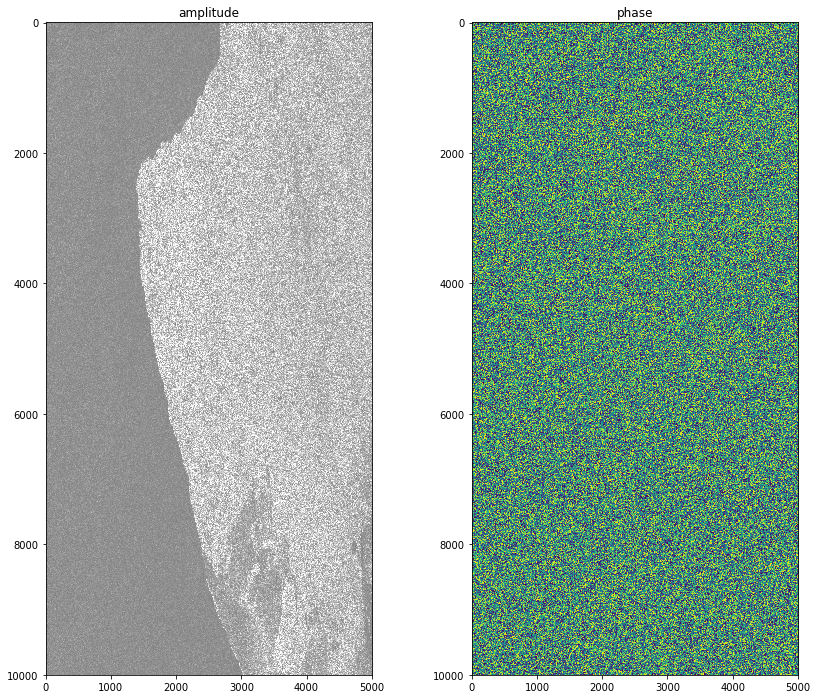

In [25]:

ds = gdal.Open("20110119_slc/20110119.slc", gdal.GA_ReadOnly)
# extract a part of the SLC to display
x0 = 0
y0 = 10000
x_offset = 5000
y_offset = 10000
slc = ds.GetRasterBand(1).ReadAsArray(x0, y0, x_offset, y_offset)
ds = None

fig = plt.figure(figsize=(14, 12))

# display amplitude of the slc
ax = fig.add_subplot(1,2,1)
ax.imshow(np.abs(slc), vmin = -2, vmax=2, cmap='gray')
ax.set_title("amplitude")

#display phase of the slc
ax = fig.add_subplot(1,2,2)
ax.imshow(np.angle(slc))
ax.set_title("phase")

plt.show()

### crop SLC

In [26]:
!stripmapApp.py stripmapApp.xml  --start=cropslc --end=cropslc

2018-07-12 11:31:51,550 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 11:31:51,561 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 11:31:51,588 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step cropslc
No region of interesting provided, skipping cropping of slc data
Dumping the application's pickle object _insar to file  PICKLE/cropslc
The remaining steps are (in order):  ['verifyDEM', 'topo', 'geo2rdr', 'coarse_resample', 'misregistration', 'refined_resample', 'dense_offsets', 'rubber_sheet', 'fine_resample', 'split_range_spectrum', 'sub_band_resample', 'interferogram', 'sub_band_interferogram', 'filter', 'filter_low_band', 'filter_high_band', 'unwrap', 'unwrap_low_band', 'unwra

Similar to crop raw data but for SLC. Since region of interest has not been specified, the whole frame is processed.

### verifyDEM

Cheks if the DEM was given in the input xml file. If the DEM is not given, then the app downloads SRTM DEM.

In [28]:
!stripmapApp.py stripmapApp.xml  --start=verifyDEM --end=verifyDEM

2018-07-12 11:33:50,976 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 11:33:50,986 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 11:33:51,012 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step verifyDEM
Polynomial Order: 0 - by - 2 
6.65625	-0.0102682	1.29377e-06	
Using native doppler information for bbox estimation
Polynomial Order: 0 - by - 2 
-7.3064	-0.00776838	9.54456e-07	
Using native doppler information for bbox estimation
command = curl -n  -L -c $HOME/.earthdatacookie -b $HOME/.earthdatacookie -k -f -O http://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.003/2000.02.11/N20W156.SRTMGL1.hgt.zip
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
       

### topo (mapping radar coordinates to geo coordinates)

In [29]:
!stripmapApp.py stripmapApp.xml  --start=topo --end=topo

2018-07-12 11:37:47,829 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 11:37:47,839 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 11:37:47,869 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step topo
2018-07-12 11:37:48,218 - isce.insar.runTopo - INFO - Running topo
Polynomial Order: 0 - by - 2 
6.65625	-0.0102682	1.29377e-06	
Using native doppler information for bbox estimation
Polynomial Order: 0 - by - 2 
-7.3064	-0.00776838	9.54456e-07	
Using native doppler information for bbox estimation
Polynomial Order: 0 - by - 2 
6.65625	-0.0102682	1.29377e-06	
2018-07-12 11:37:49,581 - isce.zerodop.topozero - WARNING - Default Peg heading set to: -2.928317862178095
Polynomial Order: 0 - 

At this step, based on the SAR acquisition geometry of the master Image (including Doppler information), platforms trajectory and an existing DEM, each pixel of the master image is geolocated. The geolocated coordinates will be at the same coordinate system of the platforms state vectors, which are usually given in WGS84 coordinate system. Moreover the incidence angle and heading angles will be computed for each pixel. 
Outputs of the step "topo" are written to "geometry" directory:


In [30]:
!ls geometry

lat.rdr.full     lon.rdr.full     los.rdr.full     z.rdr.full
lat.rdr.full.vrt lon.rdr.full.vrt los.rdr.full.vrt z.rdr.full.vrt
lat.rdr.full.xml lon.rdr.full.xml los.rdr.full.xml z.rdr.full.xml


lat.rdr.full: latitude of each pixel on the ground. "full" stands for full SAR image resolution grid (before multi-looking)

lon.rdr.full: longitude

z.rdr.full: height

los.rdr.full: incidence angle and heading angle

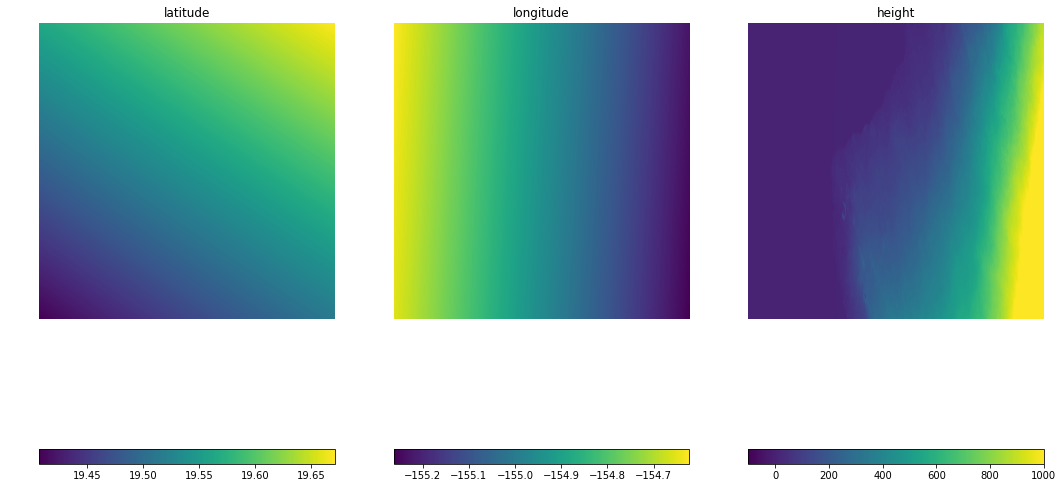

In [31]:
# Read a bounding box of latitude
ds = gdal.Open('geometry/lat.rdr.full', gdal.GA_ReadOnly)
lat = ds.GetRasterBand(1).ReadAsArray(0,10000,5000, 5000)
ds = None

# Read a bounding box of longitude
ds = gdal.Open('geometry/lon.rdr.full', gdal.GA_ReadOnly)
lon = ds.GetRasterBand(1).ReadAsArray(0,10000,5000, 5000)
ds = None

# Read a bounding box of height
ds = gdal.Open('geometry/z.rdr.full', gdal.GA_ReadOnly)
hgt = ds.GetRasterBand(1).ReadAsArray(0,10000,5000, 5000)
ds = None

fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(1,3,1)
cax=ax.imshow(lat)
ax.set_title("latitude")
ax.set_axis_off()
cbar = fig.colorbar(cax, orientation='horizontal')


ax = fig.add_subplot(1,3,2)
cax=ax.imshow(lon)
ax.set_title("longitude")
ax.set_axis_off()
cbar = fig.colorbar(cax, orientation='horizontal')


ax = fig.add_subplot(1,3,3)
cax=ax.imshow(hgt, vmin = -100, vmax=1000)
ax.set_title("height")
ax.set_axis_off()
cbar = fig.colorbar(cax, orientation='horizontal')


### geo2rdr (mapping from geo coordinates to radar coordinates)

In [32]:
!stripmapApp.py stripmapApp.xml --start=geo2rdr --end=geo2rdr

2018-07-12 11:42:16,620 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 11:42:16,631 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 11:42:16,657 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step geo2rdr
2018-07-12 11:42:17,019 - isce.insar.runGeo2rdr - INFO - Running geo2rdr
Turning off bistatic delay correction term by default.
API open (WR): offsets/range.off
API open (WR): offsets/azimuth.off
GDAL open (R): geometry/z.rdr.full.vrt
GDAL open (R): geometry/lat.rdr.full.vrt
GDAL open (R): geometry/lon.rdr.full.vrt
 Orbit interpolation method: hermite
 threads           8
 Starting Acquisition time:    73956.187049999993     
 Stop Acquisition time:    73970.591136999996     
 Azim

At this step, given the geo-ccordinates of each pixel in the master image (outputs of topo), the range and azimuth time (radar coordinates) is computed given the acquisition geometry and orbit information of the slave image. The computed range and azimuth time for the slave image, gives the pure geometrical offset, required for resampling the slave image to the master image in the next step. 

After running this step, the geometrical offsets are available in "offsets" folder:

In [49]:
!ls offsets

azimuth.off     azimuth.off.xml range.off.vrt
azimuth.off.vrt range.off       range.off.xml


azimuth.off: contains the offsets betwen master ans slave images in azimuth direction

range.off:   contains the offsets betwen master ans slave images in range direction

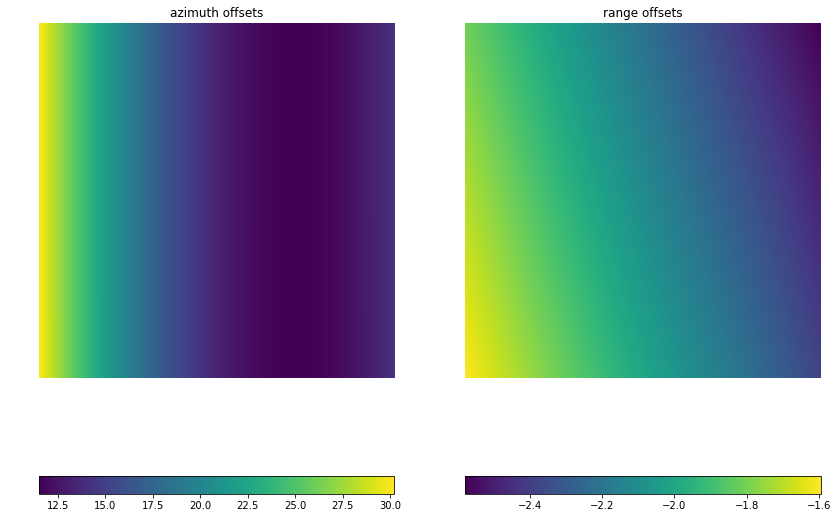

In [34]:
import gdal
import matplotlib.pyplot as plt

ds = gdal.Open('offsets/azimuth.off', gdal.GA_ReadOnly)
# extract only part of the data to display
az_offsets = ds.GetRasterBand(1).ReadAsArray(100,100,5000,5000)
ds = None

ds = gdal.Open('offsets/range.off', gdal.GA_ReadOnly)
# extract only part of the data to display
rng_offsets = ds.GetRasterBand(1).ReadAsArray(100,100,5000,5000)
ds = None

fig = plt.figure(figsize=(14, 12))

ax = fig.add_subplot(1,2,1)
cax=ax.imshow(az_offsets)
ax.set_title("azimuth offsets")
ax.set_axis_off()
cbar = fig.colorbar(cax, orientation='horizontal')

ax = fig.add_subplot(1,2,2)
cax = ax.imshow(rng_offsets)
ax.set_title("range offsets")
ax.set_axis_off()
cbar = fig.colorbar(cax, orientation='horizontal')

plt.show()

### resampling (using only geometrical offsets)

In [35]:
!stripmapApp.py stripmapApp.xml --start=coarse_resample --end=coarse_resample

2018-07-12 11:45:52,383 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 11:45:52,394 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 11:45:52,426 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step coarse_resample
2018-07-12 11:45:52,855 - isce.insar.runResampleSlc - INFO - Resampling slave SLC
Polynomial Order: 0 - by - 2 
-0.0239178	-2.54301e-05	3.12445e-09	
misreg/misreg  does not exist.
2018-07-12 11:45:53,088 - isce.stdproc.resamp_slc - WARNING - The variable INPUT_LINES has been set to the default value 27648 which is the number of lines in the slc image.
2018-07-12 11:45:53,089 - isce.stdproc.resamp_slc - WARNING - The variable INPUT_WIDTH has been set to the default value 556

At this step, the gemetrical offsets are used to resample the slave image to the same grid as the master image, i.e., the slave image is co-registered to the master image. The output of this step is written to "coregisteredSlc" folder.

In [37]:
!ls coregisteredSlc/

coarse_coreg.slc     coarse_coreg.slc.vrt coarse_coreg.slc.xml


coarse_coreg.slc: is the slave SLC coregistered to the master image

Text(0.5,1,'amplitude')

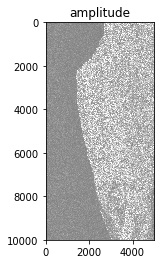

In [38]:
import gdal

ds = gdal.Open("coregisteredSlc/coarse_coreg.slc", gdal.GA_ReadOnly)
slc = ds.GetRasterBand(1).ReadAsArray(0, 10000, 5000, 10000)
ds = None

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.imshow(np.abs(slc), vmin = -2, vmax=2, cmap='gray')
ax.set_title("amplitude")



### misregistration (estimating constant offsets in range and azimuth directions)

In [40]:
!stripmapApp.py stripmapApp.xml --start=misregistration --end=misregistration

2018-07-12 11:57:21,560 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 11:57:21,572 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 11:57:21,605 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step misregistration
2018-07-12 11:57:22,044 - isce.insar.runRefineSlaveTiming - INFO - Running refine slave timing
GDAL open (R): coregisteredSlc/coarse_coreg.slc.vrt
GDAL open (R): 20110119_slc/20110119.slc.vrt
Scale Factor in Range:  1.0
Scale Factor in Azimuth:  1.0
Skip Sample Down: 687
Skip Sample Across: 121
 Input Bands:            1           1
  XXX start timer
 wisdomFile, length =            0
CAUTION - Requesting very large search window pull in
Reference Window Size is            

The range and azimuth offsets derived from pure geometry can be potentially affected by inaccuracy of orbit information or inaccurate DEMs, or inaccurate SAR metadata. The current available DEMs (e.g., SRTM DEMs) are accurate enough to estimate offsets with accuracies of 1/100 of a pixel. The Orbit information of most modern SAR sensors are also precise enough to obtain the same order of accuracy. However, inaccurate metadata (such as timing error, constant range bias), or range bulk delay may affect the estimated offsets. To account for such sources of errors the misregistration step is performed to estimate possible constant offsets between coarse coregistered SLC and master SLC. For this purpose an incoherent cross correlation is performed. 

The results of the "misregistration" step is written to the "misreg" folder.


In [41]:
!ls misreg/

misreg.db     misreg_az.xml misreg_rg.xml


In order to extract the estimated misregistration offsets:

In [43]:
import isce
import isceobj.StripmapProc.StripmapProc as St

stObj=St()
stObj.configure()

az = stObj.loadProduct("misreg/misreg_az.xml")
rng = stObj.loadProduct("misreg/misreg_rg.xml")

print("azimuth misregistration: ", az._coeffs)
print("range misregistration: ", rng._coeffs)

azimuth misregistration:  [[0.525777180619411]]
range misregistration:  [[0.9896221174721828]]


### refine_resample (resampling using geometrical offsets + misregistration)

In [44]:
!stripmapApp.py stripmapApp.xml --start=refined_resample --end=refined_resample

2018-07-12 12:06:17,766 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 12:06:17,776 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 12:06:17,806 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step refined_resample
2018-07-12 12:06:18,180 - isce.insar.runResampleSlc - INFO - Resampling slave SLC
Polynomial Order: 0 - by - 2 
-0.0239178	-2.54301e-05	3.12445e-09	
2018-07-12 12:06:18,415 - isce.insar.runResampleSlc - INFO - Geometry directory coregisteredSlc already exists.
2018-07-12 12:06:18,418 - isce.stdproc.resamp_slc - WARNING - The variable INPUT_LINES has been set to the default value 27648 which is the number of lines in the slc image.
2018-07-12 12:06:18,419 - isce.stdproc.res

At this step resampling is re-run to account for the misregistration estimated at the previous step. The new coregisterd SLC (named refined_coreg.slc) is written to the "coregisteredSlc" folder.

In [45]:
!ls coregisteredSlc/

coarse_coreg.slc      coarse_coreg.slc.xml  refined_coreg.slc.vrt
coarse_coreg.slc.vrt  refined_coreg.slc     refined_coreg.slc.xml


### optional steps ('dense_offsets', 'rubber_sheet', 'fine_resample', 'split_range_spectrum' , 'sub_band_resample')

In [46]:
!stripmapApp.py stripmapApp.xml --start=dense_offsets --end=sub_band_resample

2018-07-12 12:08:09,048 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 12:08:09,061 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 12:08:09,094 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step dense_offsets
Dumping the application's pickle object _insar to file  PICKLE/dense_offsets
The remaining steps are (in order):  ['rubber_sheet', 'fine_resample', 'split_range_spectrum', 'sub_band_resample', 'interferogram', 'sub_band_interferogram', 'filter', 'filter_low_band', 'filter_high_band', 'unwrap', 'unwrap_low_band', 'unwrap_high_band', 'ionosphere', 'geocode', 'geocodeoffsets', 'endup']
Running step rubber_sheet
Rubber sheeting not requested ... skipping
Dumping the application's

These steps are optional and will be skipped if user does not request them in the input xml file. We will get back to these steps in a different session where we estimate ionospheric phase.

### interferogram

In [47]:
!stripmapApp.py stripmapApp.xml --start=interferogram --end=interferogram

2018-07-12 12:08:19,363 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 12:08:19,373 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 12:08:19,398 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step interferogram
2018-07-12 12:08:19,684 - isce.insar.runInterferogram - INFO - igramSpectrum = full
2018-07-12 12:08:19,684 - isce.insar.runInterferogram - INFO - Generating interferogram
incidence angle at the middle of the swath:  47.40596662206409
Ground range resolution at the middle of the swath:  14.54407110605247
azimuth and range looks:  8 2
GDAL open (R): 20110119_slc/20110119.slc.vrt
GDAL open (R): coregisteredSlc/refined_coreg.slc.vrt
API open (WR): interferogram/topophase.flat
AP

At this step the master image and refined_coreg.slc is used to generate the interferogram. The generated interferogram is multi-looked based on the user inputs in the input xml file. If user does not specify the number of looks in range and azimuth directions, then they will be estimated based on posting. The default posting is 30 m which can be also specified in the input xml file.

The results of the interferogram step is written to the "interferogram" folder:

In [48]:
!ls interferogram/

topophase.amp          topophase.cor.full     topophase.cor.xml
topophase.amp.vrt      topophase.cor.full.vrt topophase.flat
topophase.amp.xml      topophase.cor.full.xml topophase.flat.vrt
topophase.cor          topophase.cor.vrt      topophase.flat.xml


topophase.flat: flattened (geometrical phase removed) and multi-looked interferogram.(one band complex64 data).

topophase.cor: coherence and magnitude for the flattened multi-looked interferogram. (two bands float32 data).

topophase.cor.full: similar to topophase.cor but at full SAR resolution.

topophase.amp: amplitudes of master amd slave images. (two bands float32) 


### sub-band interferogram

In [51]:
!stripmapApp.py stripmapApp.xml --start=sub_band_interferogram --end=sub_band_interferogram

2018-07-12 13:11:25,060 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 13:11:25,072 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 13:11:25,104 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step sub_band_interferogram
2018-07-12 13:11:25,649 - isce.insar.runInterferogram - INFO - igramSpectrum = sub
Estimating dispersive phase not requested ... skipping sub-band interferograms
Dumping the application's pickle object _insar to file  PICKLE/sub_band_interferogram
The remaining steps are (in order):  ['filter', 'filter_low_band', 'filter_high_band', 'unwrap', 'unwrap_low_band', 'unwrap_high_band', 'ionosphere', 'geocode', 'geocodeoffsets', 'endup']


This step will be skipped as we have not asked for ionospheric phase estimation. We will get back to this step in the ionospheric phase estimation notebook.

### filter

In [52]:
!stripmapApp.py stripmapApp.xml --start=filter --end=filter

2018-07-12 13:12:10,274 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 13:12:10,284 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 13:12:10,306 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step filter
2018-07-12 13:12:10,573 - isce.insar.runFilter - INFO - Applying power-spectral filter
2018-07-12 13:12:10,573 - isce.insar.runFilter - INFO - Filtering the full-band interferogram
GDAL open (R): interferogram/topophase.flat.vrt
API open (WR): interferogram/filt_topophase.flat
2018-07-12 13:12:10,594 - isce.mroipac.filter - DEBUG - width: 2781
2018-07-12 13:12:10,594 - isce.mroipac.filter - DEBUG - length: 3456
2018-07-12 13:12:10,594 - isce.mroipac.filter - DEBUG - input: interfero

A power spectral filter is applied to the multi-looked interferogram to reduce noise.


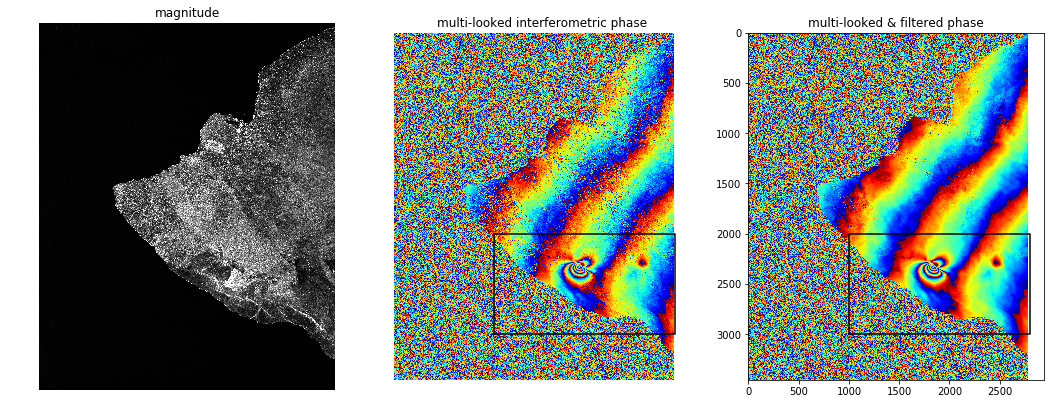

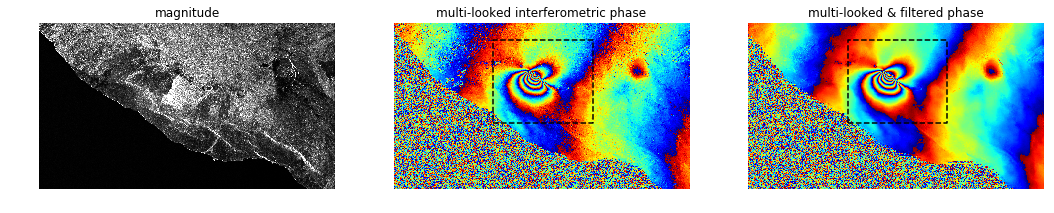

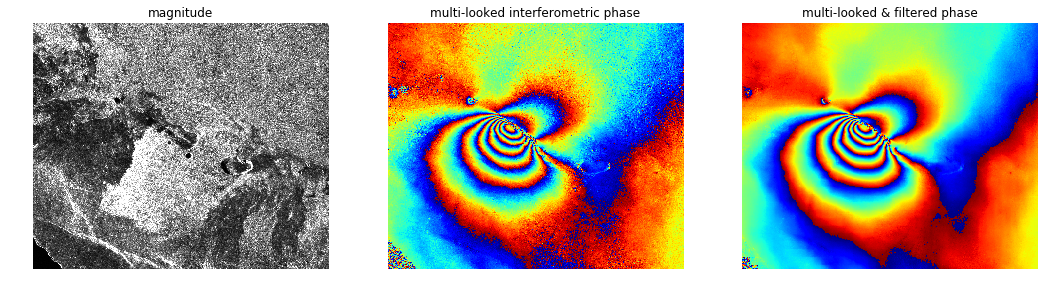

In [13]:
import gdal
import matplotlib.pyplot as plt
import numpy as np

# reading the multi-looked wrapped interferogram
ds = gdal.Open("interferogram/topophase.flat", gdal.GA_ReadOnly)
igram = ds.GetRasterBand(1).ReadAsArray()
ds = None

# reading the multi-looked un-wrapped interferogram
ds = gdal.Open("interferogram/filt_topophase.flat", gdal.GA_ReadOnly)
filt_igram = ds.GetRasterBand(1).ReadAsArray()
ds = None

fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(1,3,1)
ax.imshow(np.abs(igram), vmin = 0 , vmax = 60.0, cmap = 'gray')
ax.set_title("magnitude")
ax.set_axis_off()

ax = fig.add_subplot(1,3,2)
ax.imshow(np.angle(igram), cmap='jet')
ax.plot([1000,2800,2800,1000,1000],[3000,3000,2000,2000,3000],'-k')
ax.set_title("multi-looked interferometric phase")
ax.set_axis_off()

ax = fig.add_subplot(1,3,3)
ax.imshow(np.angle(filt_igram), cmap='jet')
ax.plot([1000,2800,2800,1000,1000],[3000,3000,2000,2000,3000],'-k')
ax.set_title("multi-looked & filtered phase")
#ax.set_axis_off()

fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(1,3,1)
ax.imshow(np.abs(igram[2000:3000, 1000:2800]), vmin = 0 , vmax = 60.0, cmap = 'gray')
ax.set_title("magnitude")
ax.set_axis_off()

ax = fig.add_subplot(1,3,2)
ax.imshow(np.angle(igram[2000:3000, 1000:2800]), cmap='jet')
ax.plot([600,1200,1200,600,600],[600,600,100,100,600],'--k')
ax.set_title("multi-looked interferometric phase")
ax.set_axis_off()

ax = fig.add_subplot(1,3,3)
ax.imshow(np.angle(filt_igram[2000:3000, 1000:2800]), cmap='jet')
ax.plot([600,1200,1200,600,600],[600,600,100,100,600],'--k')
ax.set_title("multi-looked & filtered phase")
ax.set_axis_off()

fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(1,3,1)
ax.imshow(np.abs(igram[2100:2600, 1600:2200]), vmin = 0 , vmax = 60.0, cmap = 'gray')
ax.set_title("magnitude")
ax.set_axis_off()

ax = fig.add_subplot(1,3,2)
ax.imshow(np.angle(igram[2100:2600, 1600:2200]), cmap='jet')
ax.set_title("multi-looked interferometric phase")
ax.set_axis_off()

ax = fig.add_subplot(1,3,3)
ax.imshow(np.angle(filt_igram[2100:2600, 1600:2200]), cmap='jet')
ax.set_title("multi-looked & filtered phase")
ax.set_axis_off()

<br>
<div class="alert alert-info">
<b>Note :</b> 
The interferometric phase, shows ground displacement caused by dike opening event in March 2011, along the east rift zone of Kīlauea Volcano, Hawaii.

</div>


### optional steps ('filter_low_band', 'filter_high_band')

In [54]:
!stripmapApp.py stripmapApp.xml --start=filter_low_band  --end=filter_high_band

2018-07-12 13:14:47,966 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 13:14:47,974 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 13:14:48,002 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step filter_low_band
2018-07-12 13:14:48,358 - isce.insar.runFilter - INFO - Applying power-spectral filter
Estimating dispersive phase not requested ... skipping sub-band interferograms
Dumping the application's pickle object _insar to file  PICKLE/filter_low_band
The remaining steps are (in order):  ['filter_high_band', 'unwrap', 'unwrap_low_band', 'unwrap_high_band', 'ionosphere', 'geocode', 'geocodeoffsets', 'endup']
Running step filter_high_band
2018-07-12 13:14:48,363 - isce.insar.runFilt

These steps will be skipped since we have not asked for ionospheric phase estimation in the input xml file.

### unwrap

In [55]:
!stripmapApp.py stripmapApp.xml --start=unwrap  --end=unwrap

2018-07-12 13:15:09,068 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 13:15:09,080 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 13:15:09,106 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step unwrap
GDAL open (R): interferogram/topophase.amp.vrt
GDAL open (R): interferogram/filt_topophase.flat.vrt
API open (WR): interferogram/filt_topophase.unw
API open (WR): interferogram/filt_topophase.conncomp

 << PS filtering >>


 interferogram width:  2781  number of lines/patch:  3656
 start line:        1  number of lines:    3456
 start sample:      1  end sample:         2781
 wisdomFile, length =            0

 << Unwrapping with icu, random trees 3-Nov-98 CW/PAR/SH >>

 Branch Cut 

At this step the wrapped phase of the filtered and multi-looked interferogram is unwrapped. The unwrapped interferogram is a two band data with magnitude and phase components.

[Text(0,0,'0'), Text(0,0,'1')]

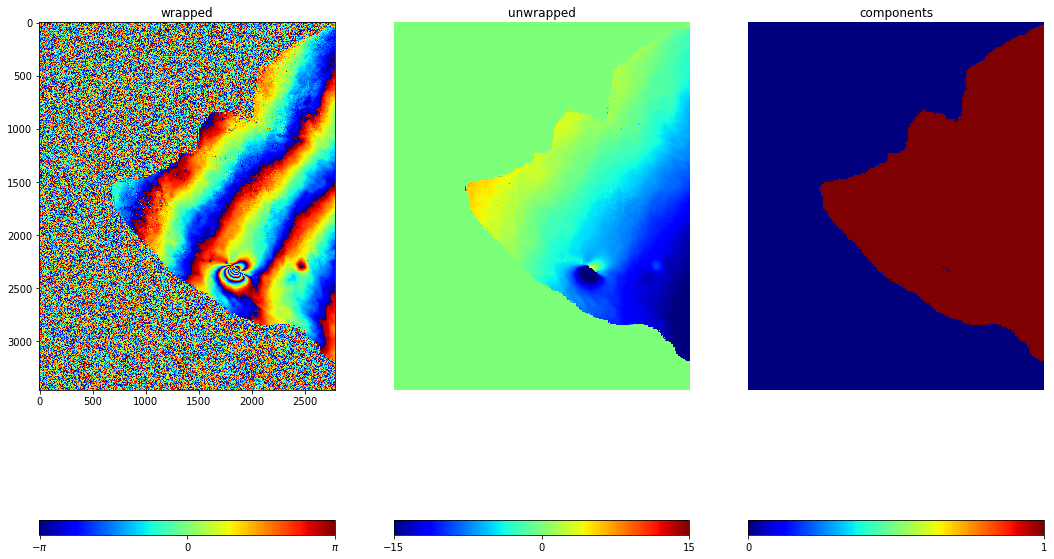

In [70]:
import gdal
import matplotlib.pyplot as plt

# reading the multi-looked wrapped interferogram
ds = gdal.Open("interferogram/filt_topophase.flat", gdal.GA_ReadOnly)
igram = ds.GetRasterBand(1).ReadAsArray()
ds = None

# reading the multi-looked unwrapped interferogram
ds = gdal.Open("interferogram/filt_topophase.unw", gdal.GA_ReadOnly)
igram_unw = ds.GetRasterBand(2).ReadAsArray()
ds = None

# reading the connected component file
ds = gdal.Open("interferogram/filt_topophase.conncomp", gdal.GA_ReadOnly)
connected_components = ds.GetRasterBand(1).ReadAsArray()
ds = None


fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(1,3,1)
cax=ax.imshow(np.angle(igram), cmap='jet')
ax.set_title("wrapped")
#ax.set_axis_off()
cbar = fig.colorbar(cax, ticks=[-3.14,0,3.14],orientation='horizontal')
cbar.ax.set_xticklabels(["$-\pi$",0,"$\pi$"])

ax = fig.add_subplot(1,3,2)
cax = ax.imshow(igram_unw, vmin = -15 , vmax = 15.0, cmap = 'jet')
ax.set_title("unwrapped")
ax.set_axis_off()
cbar = fig.colorbar(cax, ticks=[-15,0, 15], orientation='horizontal')


ax = fig.add_subplot(1,3,3)
cax = ax.imshow(connected_components, cmap = 'jet')
ax.set_title("components")
ax.set_axis_off()
cbar = fig.colorbar(cax, ticks=[0, 1] , orientation='horizontal')
cbar.ax.set_xticklabels([0,1])

<br>
<div class="alert alert-info">
<b>Note (wrapped vs unwrapped) :</b> 
Note the colorscale for the wrapped and unwrapped interferograms. The wrapped interferometric phase varies from $-\pi$ to $\pi$, while the unwrapped interferogram varies from -15 to 15 radians.
</div>

<br>
<div class="alert alert-info">
<b>Note :</b> 
The connected components file is a product of the phase unwrapping. Each interferogram may have several connected compoenets. The unwrapped phase within each component is expected to be correctly unwrapped. However, there might be $2\pi$ phase jumps between the components. Advanced ISCE users may use the 2-stage unwrapping to adjust ambiguities among different components. stripmapApp currently does not support 2-stage unwrapping. Look for this option in future releases.  
</div>


Text(0.5,1,'(unwrapped - wrapped)/(2$\\pi$)')

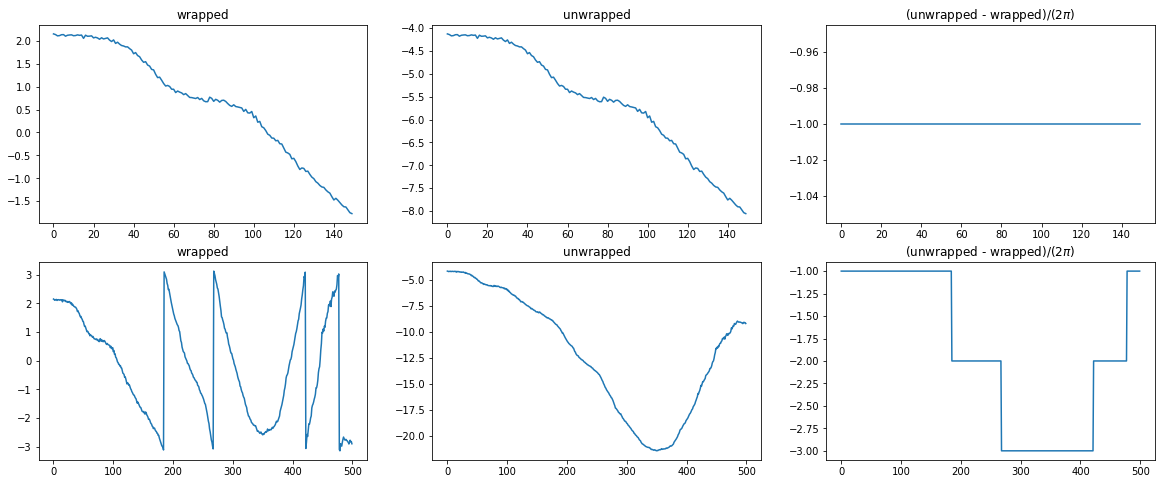

In [33]:

profile_wrapped_1 = np.angle(igram[2400,1500:1650])
profile_unwrapped_1 = igram_unw[2400,1500:1650]
profile_wrapped_2 = np.angle(igram[2400,1500:2000])
profile_unwrapped_2 = igram_unw[2400,1500:2000]

fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(2,3,1)
cax=ax.plot(profile_wrapped_1)
ax.set_title("wrapped")

ax = fig.add_subplot(2,3,2)
cax=ax.plot(profile_unwrapped_1)
ax.set_title("unwrapped")

ax = fig.add_subplot(2,3,3)
cax=ax.plot(np.round((profile_unwrapped_1-profile_wrapped_1)/2.0/np.pi))
ax.set_title("(unwrapped - wrapped)/(2$\pi$)")

ax = fig.add_subplot(2,3,4)
cax=ax.plot(profile_wrapped_2)
ax.set_title("wrapped")

ax = fig.add_subplot(2,3,5)
cax=ax.plot(profile_unwrapped_2)
ax.set_title("unwrapped")

ax = fig.add_subplot(2,3,6)
cax=ax.plot((profile_unwrapped_2-profile_wrapped_2)/2.0/np.pi)
ax.set_title("(unwrapped - wrapped)/(2$\pi$)")

#ax.set_axis_off()
#cbar = fig.colorbar(cax, ticks=[-3.14,0,3.14],orientation='horizontal')
#cbar.ax.set_xticklabels(["$-\pi$",0,"$\pi$"])

### optional steps ('unwrap_low_band', 'unwrap_high_band', 'ionosphere')

In [57]:
!stripmapApp.py stripmapApp.xml --start=unwrap_low_band  --end=ionosphere

2018-07-12 13:21:44,201 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 13:21:44,211 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 13:21:44,236 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step unwrap_low_band
Estimating dispersive phase not requested ... skipping sub-band interferogram unwrapping
Dumping the application's pickle object _insar to file  PICKLE/unwrap_low_band
The remaining steps are (in order):  ['unwrap_high_band', 'ionosphere', 'geocode', 'geocodeoffsets', 'endup']
Running step unwrap_high_band
Estimating dispersive phase not requested ... skipping sub-band interferogram unwrapping
Dumping the application's pickle object _insar to file  PICKLE/unwrap_high_band
T

Since we have not asked for ionospheric phase estimation, all these steps will be skipped.

### geocoding

In [58]:
!stripmapApp.py stripmapApp.xml --start=geocode  --end=geocode

2018-07-12 13:22:04,066 - isce.insar - INFO - ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
ISCE VERSION = 2.1.0, RELEASE_SVN_REVISION = 2366,RELEASE_DATE = 20170806, CURRENT_SVN_REVISION = 2491:2492M
2018-07-12 13:22:04,076 - root - INFO - master sensor not provided explicitly, using common sensor
2018-07-12 13:22:04,099 - root - INFO - slave sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step geocode
2018-07-12 13:22:04,387 - isce.topsinsar.runGeocode - INFO - Geocoding Image
Number of products to geocode:  6
incidence angle at the middle of the swath:  47.40596662206409
Ground range resolution at the middle of the swath:  14.54407110605247
Polynomial Order: 0 - by - 2 
6.65625	-0.0102682	1.29377e-06	
Using native doppler information for bbox estimation
Polynomial Order: 0 - by - 2 
-7.3064	-0.00776838	9.54456e-07	
Using native doppler information for bbox estimation
Output:  i

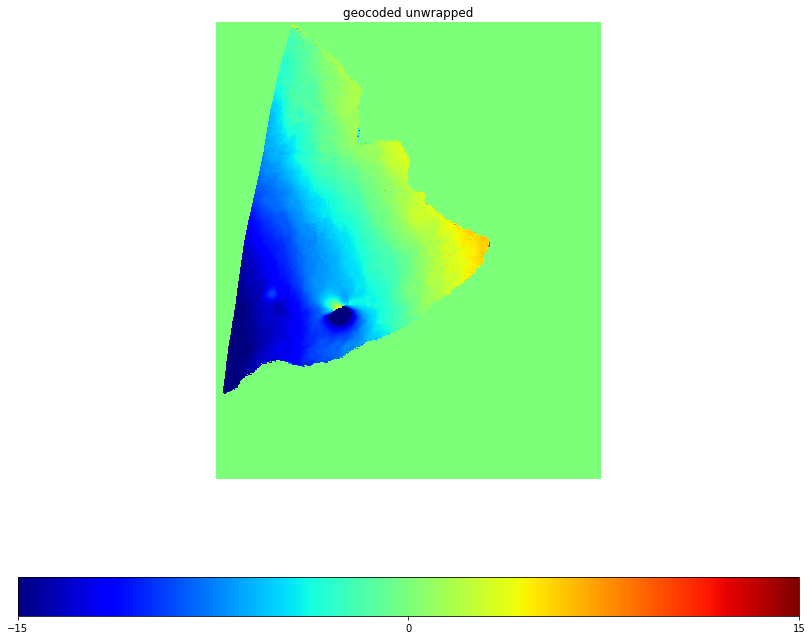

In [59]:
import gdal
import matplotlib.pyplot as plt

# reading the multi-looked wrapped interferogram
ds = gdal.Open("interferogram/filt_topophase.unw.geo", gdal.GA_ReadOnly)
unw_geocoded = ds.GetRasterBand(2).ReadAsArray()
ds = None


fig = plt.figure(figsize=(14,12))

ax = fig.add_subplot(1,1,1)
cax = ax.imshow(unw_geocoded, vmin = -15 , vmax = 15.0, cmap = 'jet')
ax.set_title("geocoded unwrapped")
ax.set_axis_off()
cbar = fig.colorbar(cax, ticks=[-15,0, 15], orientation='horizontal')

# Supplementary Information

### understanding xml files

The format of this type of file may seem unfamiliar or strange to you, but with the following description of the basics of the format, it will hopefully become more familiar.   The first thing to point out is that the indentations and line breaks seen above are not required and are simply used to make the structure more clear and the file more readable to humans.  The xml file provides structure to data for consumption by a computer.  As far as the computer is concerned the data structure is equally readable if all of the information were contained on a single very long line, but human readers would have a hard time reading it in that format. 

The next thing to point out is the method by which the data are structured through the use of tags and attributes.  An item enclosed in the < (less-than) and > (greater-than) symbols is referred to as a tag.  The name enclosed in the < and > symbols is the name of the tag.  Every tag in an xml file must have an associated closing tag that contains the same name but starts with the symbol </ and ends with the symbol >.  This is the basic unit of structure given to the data.  Data are enclosed inside of opening and closing tags that have names identifying the enclosed data.  This structure is nested to any order of nesting necessary to represent the data.  The Python language (in which the ISCE user interface is written) provides powerful tools to parse the xml structure into a data structure object and to very easily “walk” through the structure of that object.  

In the above xml file the first and last tags in the file are a tag pair: <stripmapApp> and </stripmapApp> (note again, tags must come in pairs like this).  The first of these two tags, or the opening tag,  marks the beginning of the contents of the tag and the second of these two tags, or the closing tag, marks the end of the contents of the tag.  ISCE expects a “file tag” of this nature to bracket all inputs contained in the file.  The actual name of the file tag, as far as ISCE is concerned, is user selectable.  In this example it is used, as a convenience to the user, to document the ISCE application, named insarApp.py, for which it is meant to provide inputs; it could have been named <foo> and insarApp.py would have been equally happy provided that the closing tag were </foo>.  

The next tag  is <component name="insar">.  Its closing tag </component> is located at the penultimate line of the file (one line above the </insar> tag). The name of this tag is component and it has an attribute called name with value “insarApp”. The component tags bound a collection of information that is used by a computational element within ISCE that has the name specified by the name attribute.   The name “insarApp”  in the first component tag tells ISCE that the enclosed information correspond to a functional component in ISCE named “insarApp”, which in this case is actually the application that is run at the command line.  

In general, component tags contain information in the form of other component tags or property tags, all of which can be nested to any required level. In this example the  insarApp component contains a property tag and two other component tags.

The first tag we see in the insarApp component tag is the property tag with attribute name=“sensor name”. The property tag contains a value tag that contains the name of the sensor, ALOS in this case.  The next tag is a component tag with attribute name=”Master”. This tag contains a catalog tag containing  Master.xml.  The catalog tag in general informs ISCE to look in the named file (Master.xml in this case) for the contents of the current tag.  The next component tag has the same structure with the catalog  tag containing a different file named Slave.xml.

### Extra configuration parameters 

The input configuration file in this tutorial only included mandatory parameters including the master and slave images, which are enough to run the application. This means that the application is configured with default parameters hardwired in the code or computed during processing. 
For custom processing, user may want to set parameters in the input configuration file. In the following a few more parameters are shown that can be added to stripmapApp.xml. 

### regionOfInterest

To specify a region of interest to process:

```xml
<property name="regionOfInterest">[South, North, West, East]</property>
```

Example: 

```xml
<property name="regionOfInterest">[19.0, 19.9, -155.4, -154.7]</property>
```

Default: Full frame is processed.

### range looks
number of looks in range direction 

```xml
<property name="range looks">USER_INPUT</property>
```

Deafult: is computed based on the posting parameter.

### azimuth looks
number of looks in azimuth direction 

Deafult: is computed based on the posting parameter.


### posting
Interferogram posting in meters.

```xml
<property name="posting">USER_INPUT</property>
```

Default: 30

<br>
<div class="alert alert-info">
<b>Note :</b> 
If "range looks" and "azimuth looks" have not been specified, then posting is used to compute them such that the interferogram is generated with a roughly square pixels size with each dimension close to the "posting" parameter.

</div>

### filter strength

strength of the adaptive filter used for filtering the wrapped interferogram

```xml
<property name="filter strength">USER_INPUT</property>
```

Default: 0.5


### useHighResolutionDemOnly
```xml
<property name="useHighResolutionDemOnly">True</property>
```

If True and a dem is not specified in input, it will only
    download the SRTM highest resolution dem if it is available
    and fill the missing portion with null values (typically -32767)

Default: False

### do unwrap

To turn phase unwrapping off
```xml
<property name="do unwrap">False</property>
```

Default: True


### unwrapper name
To choose the name of the phase unwrapping method. e.g., to choose "snaphu" for phase unwrapping
```xml
<property name="unwrapper name">snaphu</property>
```

Default: "icu".




### do rubbersheeting

To turn on rubbersheeting (estimating azimuth offsets caused by strong ionospheric scentilation)

```xml
<property name="do rubbersheeting">True</property>
```
Default : False

### rubber sheet SNR Threshold

```xml
<property name="rubber sheet SNR Threshold">USER_INPUT</property>
```
If "do rubbersheeting" is turned on, then this values is used to mask out azimuth offsets with SNR less that the input threshold. 

Default: 5

### rubber sheet filter size
the size of the median filter used for filtering the azimuth offsets

```xml
<property name="rubber sheet filter size">USER_INPUT</property>
```

Default: 8

### do denseoffsets
turn on the dense offsets computation from cross correlation

```xml
<property name="do denseoffsets">True</property>
```

Default: False

<br>
<div class="alert alert-info">
<b>Note :</b> 

If "do rubbersheeting" is turned on, then dense offsets computation is turned on regardless of the user input for "do denseoffsets"

</div>

### setting the dense offsets parameters 

```xml
<property name="dense window width">USER_INPUT</property>
<property name="dense window height">USER_INPUT</property>
<property name="dense search width">USER_INPUT</property>
<property name="dense search height">USER_INPUT</property>
<property name="dense skip width">USER_INPUT</property>
<property name="dense skip height">USER_INPUT</property>
```

Default values:
<br>
    dense window width  = 64 
<br>
    dense window height = 64
<br>
    dense search width  = 20
<br>
    dense search height = 20
<br>
    dense skip width    = 32
<br>
    dense skip height   = 32


### geocode list

List of products to be geocoded.
```xml
<property name="geocode list">"a list of files to geocode">
```
Default: multilooked, filtered wrapped and unwrapped interferograms, coherence, ionospehric phase

### offset geocode list
List of offset-specific files to geocode
```xml
<property name="offset geocode list">"a list of offset files to geocode">
```


### do split spectrum

turn on split spectrum 

```xml
<property name="do split spectrum">True</property>
```

Default: False

### do dispersive
turn on disperive phase estimation

```xml
<property name="do dispersive">True</property>
```

Default: False

<br>
<div class="alert alert-info">
<b>Note :</b> 

By turning on "do dispersive", the user input for "do split spectrum" is ignored and the split spectrum will be turned on as it is needed for dispersive phase estimation. 

</div>


### control the filter kernel for filtering the dispersive phase  
```xml
<property name="dispersive filter kernel x-size">800</property>
<property name="dispersive filter kernel y-size">800</property>
<property name="dispersive filter kernel sigma_x">100</property>
<property name="dispersive filter kernel sigma_y">100</property>
<property name="dispersive filter kernel rotation">0</property>
<property name="dispersive filter number of iterations">5</property>
<property name="dispersive filter mask type">coherence</property>
<property name="dispersive filter coherence threshold">0.6</property>
    
```    



### processing data from other stripmap sensors

stripmapApp.py is able to process the stripmap data from the following sensors. So far it has been sucessfully tested on the following sensors: 
    <br>
    ALOS1 (Raw and SLC)
    ALOS2 (SLC, one frame)
    COSMO_SkyMed (Raw and SLC)
    ERS
    ENVISAT ()
    Radarsat-1
    Radarsat-2
    TerraSARX
    TanDEMX
    Sentinel1
    
    
    envisat_slc
    
    
### Sample input data xml for different sensors:

#### Envisat: 
```xml

<component name="master">
    <property name="IMAGEFILE">data/ASA_IMS_1PNESA20050519_140259_000000172037_00239_16826_0000.N1</property>
    <property name="INSTRUMENT_DIRECTORY">/u/k-data/agram/sat_metadata/ENV/INS_DIR</property>
    <property name="ORBIT_DIRECTORY">/u/k-data/agram/sat_metadata/ENV/Doris/VOR</property>
    <property name="OUTPUT">
        20050519
    </property>
</component>

```

<br>
<div class="alert alert-info">
<b>Note :</b> 
Note that for processing the ENVISAT data a directory that contains the orbits is required. 
</div>


### Sentinel-1 stripmap:
```xml
    <component name="master">
      <property name="orbit directory">/u/data/sat_metadata/S1/aux_poeorb/</property>
      <property name="output">20151024</property>
      <property name="safe">/u/data/S1A_S1_SLC__1SSV_20151024T234201_20151024T234230_008301_00BB43_068C.zip</property>
    </component>
    <component name="slave">
      <property name="orbit directory">/u/k-raw/sat_metadata/S1/aux_poeorb/</property>
      <property name="output">20150930</property>
      <property name="safe">/u/data/S1A_S1_SLC__1SSV_20150930T234200_20150930T234230_007951_00B1CC_121C.zip</property>
    </component>
```

<br>
<div class="alert alert-info">
<b>Note :</b> 
Note that for processing the Sentinel-1 data a directory that contains the orbits is required. 
</div>

### ALOS2 SLC
```xml
<component>
    <property name="IMAGEFILE">
        <value>data/20141114/ALOS2025732920-141114/IMG-HH-ALOS2025732920-141114-UBSL1.1__D</value>
    </property>
    <property name="LEADERFILE">
        <value>data/20141114/ALOS2025732920-141114/LED-ALOS2025732920-141114-UBSL1.1__D</value>
    </property>
    <property name="OUTPUT">
        <value>20141114</value>
    </property>
</component>
```

### ALOS1 raw data
``` xml
<component>
    <property name="IMAGEFILE">
       <value>[data/20110119/ALPSRP265743230-L1.0/IMG-HH-ALPSRP265743230-H1.0__D]</value>
    </property>
    <property name="LEADERFILE">
        <value>[data/20110119/ALPSRP265743230-L1.0/LED-ALPSRP265743230-H1.0__D]</value>
    </property>
    <property name="OUTPUT">
        <value>20110119</value>
    </property>
</component>
```

### CosmoSkyMed raw or SLC data

```xml
<component name="master">
    <property name="HDF5">data/CSKS3_RAW_B_HI_03_HH_RD_SF_20111007021527_20111007021534.h5</property>
    <property name="OUTPUT">
        20111007
    </property>
</component>

```

### TerraSAR-X and TanDEM-X

```xml
<component name="master">
    <property name="xml">PATH_TO_TSX_DATA_XML</property>
    <property name="OUTPUT">OUTPUT_NAME</property> 
</component>    
```


### Using ISCE as a python library

ISCE can be used a python library. Users can develop their own workflows within ISCE framework. Here are few simple examples where we try to call isce modules:


#### Example 1: (extract metadata, range and azimuth pixel size)

In [44]:
import isce
import isceobj
import isceobj.StripmapProc.StripmapProc as St
from isceobj.Planet.Planet import Planet

stObj = St()
stObj.configure()
frame = stObj.loadProduct("20110119_slc.xml")
print("Wavelength = {0} m".format(frame.radarWavelegth))
print("Slant Range Pixel Size = {0} m".format(frame.instrument.rangePixelSize))

#For azimuth pixel size we need to multiply azimuth time interval by the platform velocity along the track

# the acquisition time at the middle of the scene
t_mid = frame.sensingMid

#get the orbit for t_mid
st_mid=frame.orbit.interpolateOrbit(t_mid)

# platform velocity
Vs = st_mid.getScalarVelocity()

# pulse repitition frequency
prf = frame.instrument.PRF

#Azimuth time interval 
ATI = 1.0/prf

#Azimuth Pixel size
az_pixel_size = ATI*Vs
print("Azimuth Pixel Size = {0} m".format(az_pixel_size))





Wavelength = 0.2360571 m
Slant Range Pixel Size = 9.3685143125 m
Azimuth Pixel Size = 3.957064604542756 m


#### Example 2: compute ground range pixels size

In [47]:
r0 = frame.startingRange
rmax = frame.getFarRange()
rng =(r0+rmax)/2

elp = Planet(pname='Earth').ellipsoid
tmid = frame.sensingMid

sv = frame.orbit.interpolateOrbit( tmid, method='hermite') #.getPosition()
llh = elp.xyz_to_llh(sv.getPosition())


hdg = frame.orbit.getENUHeading(tmid)
elp.setSCH(llh[0], llh[1], hdg)
sch, vsch = elp.xyzdot_to_schdot(sv.getPosition(), sv.getVelocity())

Re = elp.pegRadCur
H = sch[2]
cos_beta_e = (Re**2 + (Re + H)**2 -rng**2)/(2*Re*(Re+H))
sin_bet_e = np.sqrt(1 - cos_beta_e**2)
sin_theta_i = sin_bet_e*(Re + H)/rng
print("incidence angle at the middle of the swath: ", np.arcsin(sin_theta_i)*180.0/np.pi)
groundRangeRes = frame.instrument.rangePixelSize/sin_theta_i
print("Ground range pixel size: {0} m ".format(groundRangeRes))


incidence angle at the middle of the swath:  47.40596662206409
Ground range pixel size: 12.726062217795912 m 


#### Example 3: another way to compute the incidence angle

In [54]:
#get the state vector at the middle of the scene
st = frame.orbit.interpolateOrbit(t_mid)

#extract position for this state vector
S = st.position

#compute target position for a pixel at mid swath (mid azimuth time and mid range)
T = frame.orbit.rdr2geo(t_mid,rng)

# convert lat lon height of the target to XYZ
refElp = Planet(pname='Earth').ellipsoid
Txyz = refElp.llh_to_xyz(T)

# vector from Target to Sensor (TS)
TS = [S[0]-Txyz[0], S[1]-Txyz[1], S[2]-Txyz[2]]

# dot product of the Target vector and TS
TS_dot_Txyz = TS[0]*Txyz[0]+TS[1]*Txyz[1]+TS[2]*Txyz[2]

#Magnitude of TS vector
TS_mag = np.sqrt(TS[0]**2+TS[1]**2+TS[2]**2)

#Magnitude of the target vector
Txyz_mag = np.sqrt(Txyz[0]**2+Txyz[1]**2+Txyz[2]**2)

#incidence angle is the angle between the TS and T vectors
theta = np.arccos(TS_dot_Txyz/(TS_mag*Txyz_mag))*180./np.pi
print("incidence angle at the middle of the swath:", theta)


incidence angle at the middle of the swath: 47.46986976883387


<br>
<div class="alert alert-info">
<b>Note :</b> 
One can easily get the incidence angle from the los.rdr file inside geometry folder. Even without opening the file, here is a way to get the statistics and the average value of the incidence angle:  gdalinfo geometry/los.rdr -stats
</div>